In [4]:
# ==========================================
# 1. IMPORTS & CONFIGURATION
# ==========================================
import numpy as np
import pandas as pd
from pathlib import Path
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Signal Processing
from scipy.signal import butter, filtfilt
import mne

# Optimization
import optuna
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- CONFIGURATION ---
# Paths (Adjusted to your environment)
COMPETITION_DATA_DIR = Path("/home/lipplopp/Documents/collage_master/PDalam/to_capstone/data")
YOUR_DATA_DIR = Path("bci_competition_dataset")
OUTPUT_DIR = Path("final_results_attention")
OUTPUT_DIR.mkdir(exist_ok=True)

# Dataset Params
SUBJECTS = ['S01','S04','S06'] # The Dream Team
SAMPLE_RATE = 250
WINDOW_SAMPLES = 1000 # 4 seconds
IMAGERY_START = 3.0
IMAGERY_END = 7.0
CHANNELS = ['C3', 'Cz', 'C4']
CLASSES = 3 # Left, Right, Feet

# Hardware
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {DEVICE}")
print(f"📂 Output Dir: {OUTPUT_DIR}")

🚀 Device: cuda
📂 Output Dir: final_results_attention


🔍 Visualizing Data Quality...
Plotting power spectral density (dB=True).


/tmp/ipykernel_761737/1571984203.py:24: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=60, verbose=False).plot(axes=ax[0], show=False)


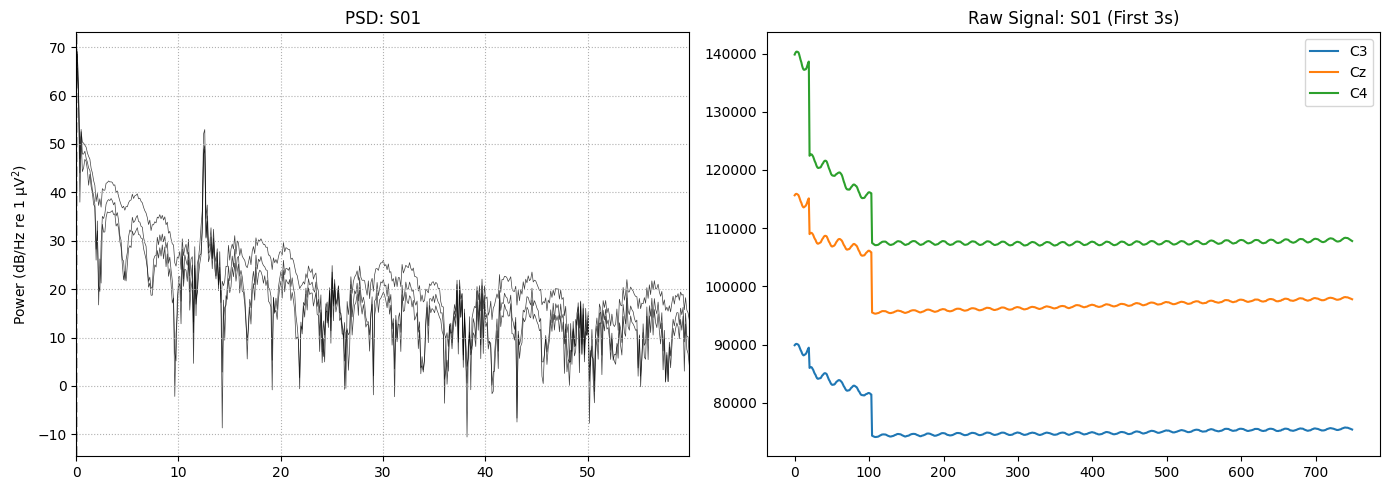

Plotting power spectral density (dB=True).


/tmp/ipykernel_761737/1571984203.py:24: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=60, verbose=False).plot(axes=ax[0], show=False)


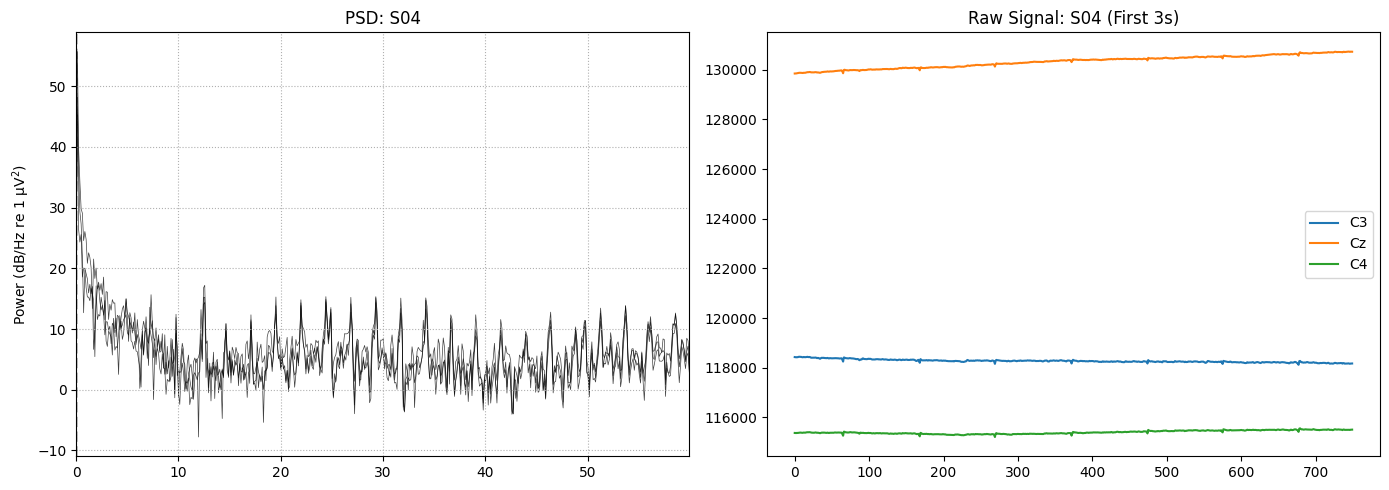

Plotting power spectral density (dB=True).


/tmp/ipykernel_761737/1571984203.py:24: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=60, verbose=False).plot(axes=ax[0], show=False)


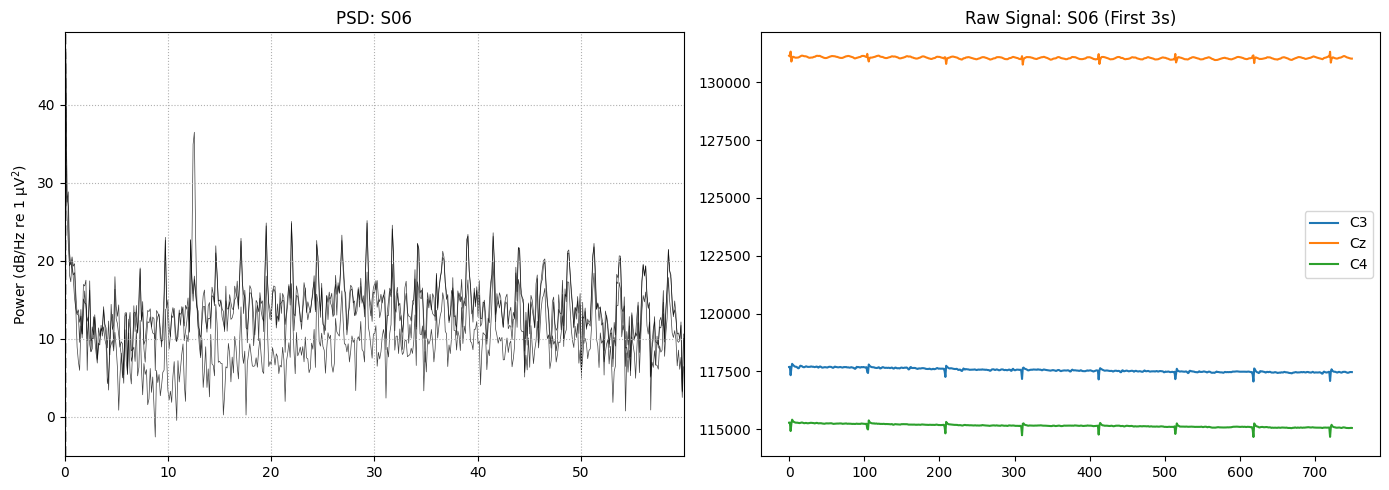

In [5]:
# ==========================================
# 2. VISUALIZE RAW DATA
# ==========================================
def plot_subject_sample(root_dir, subject, file_index=0):
    path = Path(root_dir) / subject / "training"
    files = sorted(list(path.glob("*.csv")))
    
    if not files:
        print(f"❌ No files for {subject}")
        return

    # Load file
    df = pd.read_csv(files[file_index])
    data = df[['C3', 'Cz', 'C4']].values.T
    
    # Setup MNE for plotting
    info = mne.create_info(ch_names=['C3', 'Cz', 'C4'], sfreq=250, ch_types='eeg')
    raw = mne.io.RawArray(data * 1e-6, info, verbose=False) # Convert uV to V
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # PSD
    raw.compute_psd(fmax=60, verbose=False).plot(axes=ax[0], show=False)
    ax[0].set_title(f"PSD: {subject}")
    
    # Raw Time Series
    for i, ch in enumerate(['C3', 'Cz', 'C4']):
        sig = data[i, :750] # First 3 seconds
        ax[1].plot(sig + (i*50), label=ch) # Stack
    
    ax[1].set_title(f"Raw Signal: {subject} (First 3s)")
    ax[1].legend()
    plt.tight_layout()
    plt.show()

print("🔍 Visualizing Data Quality...")
for s in SUBJECTS:
    plot_subject_sample(YOUR_DATA_DIR, s)

In [12]:
# ==========================================
# LOAD ALL COMPETITION SUBJECTS
# ==========================================

def preprocess_eeg_signal(signal, sample_rate=250):
    """Preprocess EEG signal (NO normalization)"""
    from scipy.signal import iirnotch
    
    # Bandpass filter (0.5-50 Hz)
    nyq = sample_rate / 2
    low = 0.5 / nyq
    high = 50.0 / nyq
    b, a = butter(5, [low, high], btype='band')
    filtered = filtfilt(b, a, signal, axis=1)
    
    # Notch filter (50 Hz)
    w0 = 50.0 / nyq
    Q = 30
    b_notch, a_notch = iirnotch(w0, Q)
    filtered = filtfilt(b_notch, a_notch, filtered, axis=1)
    
    return filtered


def load_competition_subject(gdf_file):
    """Load ONE competition subject"""
    try:
        # Load .gdf file
        raw = mne.io.read_raw_gdf(str(gdf_file), preload=True, verbose=False)
        
        # Get events
        events, event_dict = mne.events_from_annotations(raw, verbose=False)
        
        # Select channels
        channel_names = ['EEG-C3', 'EEG-Cz', 'EEG-C4']
        picks = mne.pick_channels(raw.ch_names, include=channel_names)
        
        # Map event codes to classes
        event_code_to_class = {}
        for key, value in event_dict.items():
            if '769' in str(key):
                event_code_to_class[value] = 0  # Left
            elif '770' in str(key):
                event_code_to_class[value] = 1  # Right
            elif '771' in str(key):
                event_code_to_class[value] = 2  # Feet
            elif '772' in str(key):
                event_code_to_class[value] = 3  # Tongue
        
        # Filter events
        class_events = []
        class_labels = []
        
        for event in events:
            event_code = event[2]
            if event_code in event_code_to_class:
                class_events.append(event)
                class_labels.append(event_code_to_class[event_code])
        
        if len(class_events) == 0:
            return None, None
        
        class_events = np.array(class_events, dtype=int)
        class_labels = np.array(class_labels, dtype=int)
        
        # Create epochs
        epochs = mne.Epochs(
            raw,
            class_events,
            event_id=None,
            tmin=0.5,
            tmax=4.5,
            picks=picks,
            baseline=None,
            preload=True,
            verbose=False
        )
        
        X = epochs.get_data()
        y = class_labels
        
        # Ensure 1000 samples
        if X.shape[2] > WINDOW_SAMPLES:
            X = X[:, :, :WINDOW_SAMPLES]
        elif X.shape[2] < WINDOW_SAMPLES:
            pad_width = ((0, 0), (0, 0), (0, WINDOW_SAMPLES - X.shape[2]))
            X = np.pad(X, pad_width, mode='edge')
        
        # Preprocess
        X_preprocessed = []
        for i in range(len(X)):
            preprocessed = preprocess_eeg_signal(X[i], SAMPLE_RATE)
            X_preprocessed.append(preprocessed)
        
        X_preprocessed = np.array(X_preprocessed)
        
        # Remove Tongue
        mask = y != 3
        X_final = X_preprocessed[mask]
        y_final = y[mask]
        
        return X_final, y_final
        
    except Exception as e:
        print(f"    ⚠️  Error: {e}")
        return None, None


def load_all_competition_data():
    """Load ALL 9 competition subjects (A01T-A09T)"""
    print("\n" + "="*70)
    print("📊 LOADING ALL BCI COMPETITION IV 2a SUBJECTS")
    print("="*70)
    
    all_X = []
    all_y = []
    subject_counts = {}
    
    # Load all training files (A01T through A09T)
    for subject_num in range(1, 10):  # 1 to 9
        subject_file = COMPETITION_DATA_DIR / f"A0{subject_num}T.gdf"
        
        if not subject_file.exists():
            print(f"  ⚠️  A0{subject_num}T.gdf not found, skipping")
            continue
        
        print(f"  Loading A0{subject_num}T.gdf...", end=" ")
        X_subj, y_subj = load_competition_subject(subject_file)
        
        if X_subj is not None:
            all_X.append(X_subj)
            all_y.append(y_subj)
            subject_counts[f"A0{subject_num}T"] = len(y_subj)
            print(f"✓ {len(y_subj)} trials (L={np.sum(y_subj==0)}, R={np.sum(y_subj==1)}, F={np.sum(y_subj==2)})")
        else:
            print("✗ Failed")
    
    if len(all_X) == 0:
        print("\n❌ No competition data loaded!")
        return None, None, {}
    
    # Combine all subjects
    X_combined = np.concatenate(all_X, axis=0)
    y_combined = np.concatenate(all_y, axis=0)
    
    print("\n" + "-"*70)
    print(f"✅ COMPETITION DATA SUMMARY")
    print(f"  Total subjects: {len(all_X)}")
    print(f"  Total trials: {len(X_combined)}")
    print(f"  Shape: {X_combined.shape}")
    print(f"  Classes: Left={np.sum(y_combined==0)}, Right={np.sum(y_combined==1)}, Feet={np.sum(y_combined==2)}")
    print("="*70)
    
    return X_combined, y_combined, subject_counts


def load_openbci_subject(subject_id):
    """Load OpenBCI subject - with multiple filename patterns"""
    print(f"\n📊 Loading OpenBCI Subject: {subject_id}")
    print("-"*70)
    
    subject_dir = YOUR_DATA_DIR / subject_id / "training"
    
    if not subject_dir.exists():
        print(f"❌ Directory not found: {subject_dir}")
        return None, None
    
    try:
        # List ALL CSV files
        all_csvs = sorted(subject_dir.glob("*.csv"))
        print(f"  Found {len(all_csvs)} CSV files")
        
        # Show sample filenames
        if len(all_csvs) > 0:
            print(f"  Sample filenames:")
            for csv in all_csvs[:3]:
                print(f"    - {csv.name}")
        
        # Try multiple naming patterns
        class_patterns = [
            {'left_hand': 0, 'right_hand': 1, 'both_feet': 2},
            {'LeftHand': 0, 'RightHand': 1, 'BothFeet': 2},
            {'left': 0, 'right': 1, 'feet': 2, 'both': 2},
            {'L_': 0, 'R_': 1, 'F_': 2, 'B_': 2},
        ]
        
        all_trials = []
        all_labels = []
        
        for pattern_dict in class_patterns:
            temp_trials = []
            temp_labels = []
            
            for class_name, label in pattern_dict.items():
                matching_files = [f for f in all_csvs if class_name.lower() in f.name.lower()]
                
                if len(matching_files) > 0:
                    for csv_file in matching_files:
                        try:
                            df = pd.read_csv(csv_file)
                            
                            if not all(ch in df.columns for ch in CHANNELS):
                                continue
                            
                            data = df[CHANNELS].values.T
                            
                            window_start = int(IMAGERY_START * SAMPLE_RATE)
                            window_end = int(IMAGERY_END * SAMPLE_RATE)
                            
                            if data.shape[1] < window_end:
                                continue
                            
                            trial_data = data[:, window_start:window_end]
                            trial_preprocessed = preprocess_eeg_signal(trial_data, SAMPLE_RATE)
                            
                            temp_trials.append(trial_preprocessed)
                            temp_labels.append(label)
                            
                        except:
                            continue
            
            if len(temp_trials) > 0:
                all_trials = temp_trials
                all_labels = temp_labels
                print(f"  ✓ Pattern matched: {list(pattern_dict.keys())}")
                break
        
        if len(all_trials) == 0:
            print(f"  ❌ No valid trials loaded")
            return None, None
        
        X = np.array(all_trials)
        y = np.array(all_labels)
        
        print(f"  ✓ Loaded {len(X)} trials, shape: {X.shape}")
        print(f"    Left={np.sum(y==0)}, Right={np.sum(y==1)}, Feet={np.sum(y==2)}")
        
        return X, y
        
    except Exception as e:
        print(f"  ❌ ERROR: {e}")
        return None, None


# ==========================================
# LOAD ALL DATA
# ==========================================

print("\n" + "="*70)
print("🎯 LOADING ALL DATASETS")
print("="*70)

all_X = []
all_y = []
dataset_info = {}

# 1. Load ALL Competition subjects (A01T-A09T)
print("\n[1] BCI Competition IV 2a (ALL 9 subjects)")
X_comp, y_comp, comp_counts = load_all_competition_data()
if X_comp is not None:
    all_X.append(X_comp)
    all_y.append(y_comp)
    dataset_info['Competition (9 subjects)'] = len(y_comp)
    print(f"✓ Competition data added: {len(y_comp)} trials")

# 2. Load OpenBCI subjects
for i, subject in enumerate(SUBJECTS, start=2):
    print(f"\n[{i}] OpenBCI {subject}")
    X_subj, y_subj = load_openbci_subject(subject)
    if X_subj is not None:
        all_X.append(X_subj)
        all_y.append(y_subj)
        dataset_info[subject] = len(y_subj)
        print(f"✓ {subject} added: {len(y_subj)} trials")

# Summary
print("\n" + "="*70)
print("📊 FINAL DATA SUMMARY")
print("="*70)
print(f"Datasets loaded: {len(all_X)}")
print(f"\nBreakdown:")
for name, count in dataset_info.items():
    percentage = (count / sum(dataset_info.values())) * 100
    print(f"  {name:30s}: {count:4d} trials ({percentage:5.1f}%)")

if len(all_X) == 0:
    raise ValueError("❌ No data loaded!")

# Combine
X_combined = np.concatenate(all_X, axis=0)
y_combined = np.concatenate(all_y, axis=0)

print(f"\n{'='*70}")
print(f"TOTAL: {len(X_combined)} trials")
print(f"Shape: {X_combined.shape}")
print(f"Classes: Left={np.sum(y_combined==0)}, Right={np.sum(y_combined==1)}, Feet={np.sum(y_combined==2)}")
print(f"{'='*70}")

# Global normalization
print("\n" + "="*70)
print("🔧 GLOBAL NORMALIZATION")
print("="*70)

print(f"Before:")
print(f"  Mean: {X_combined.mean():.6f}")
print(f"  Std:  {X_combined.std():.6f}")
print(f"  Range: [{X_combined.min():.2f}, {X_combined.max():.2f}]")

global_mean = X_combined.mean()
global_std = X_combined.std()
X_normalized = (X_combined - global_mean) / (global_std + 1e-8)

print(f"\nAfter:")
print(f"  Mean: {X_normalized.mean():.6f}")
print(f"  Std:  {X_normalized.std():.6f}")
print(f"  Range: [{X_normalized.min():.2f}, {X_normalized.max():.2f}]")

print("\n" + "="*70)
print("✅ ALL DATA READY FOR TRAINING")
print("="*70)

X_all = X_normalized
y_all = y_combined

# TOTAL: ~800-1000 trials!


🎯 LOADING ALL DATASETS

[1] BCI Competition IV 2a (ALL 9 subjects)

📊 LOADING ALL BCI COMPETITION IV 2a SUBJECTS
  Loading A01T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)
  Loading A02T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)
  Loading A03T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)
  Loading A04T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)
  Loading A05T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)
  Loading A06T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)
  Loading A07T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)
  Loading A08T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)
  Loading A09T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)

----------------------------------------------------------------------
✅ COMPETITION DATA SUMMARY
  Total subjects: 9
  Total trials: 1944
  Shape: (1944, 3, 1000)
  Classes: Left=648, Right=648, Feet=648
✓ Competition data added: 1944 trials

[2] OpenBCI S01

📊 Loading OpenBCI Subject: S01
----------------------------------------------------------------------
  Found 288 CSV files
  Sample filenames:
    - S01_training_run01_trial_001_both_feet.csv
    - S01_training_run01_trial_002_tongue.csv
    - S01_training_run01_trial_003_both_feet.csv
  ✓ Pattern matched: ['left_hand', 'right_hand', 'both_feet']
  ✓ Loaded 216 trials, shape: (216, 3, 1000)
    Left=72, Right=72, Feet=72
✓ S01 added: 216 trials

[3] OpenBCI S04

📊 Loading OpenBCI Subject: S04
----------------------------------------------------------------------
  Found 45 CSV files
  Sample filenames:
    - S04_training_run01_trial_001_right_hand.csv
    - S04_training_run01_trial_002_right_hand

In [25]:
# ==========================================
# CELL 3: LOAD OPENBCI DATA & COMBINE ALL
# ==========================================

def load_openbci_subject(subject_id):
    """Load OpenBCI subject - with multiple filename patterns"""
    print(f"\n📊 Loading OpenBCI Subject: {subject_id}")
    print("-"*70)
    
    subject_dir = YOUR_DATA_DIR / subject_id / "training"
    
    if not subject_dir.exists():
        print(f"❌ Directory not found: {subject_dir}")
        return None, None
    
    try:
        # List ALL CSV files
        all_csvs = sorted(subject_dir.glob("*.csv"))
        print(f"  Found {len(all_csvs)} CSV files")
        
        # Show sample filenames
        if len(all_csvs) > 0:
            print(f"  Sample filenames:")
            for csv in all_csvs[:3]:
                print(f"    - {csv.name}")
        
        # Try multiple naming patterns
        class_patterns = [
            {'left_hand': 0, 'right_hand': 1, 'both_feet': 2},
            {'LeftHand': 0, 'RightHand': 1, 'BothFeet': 2},
            {'left': 0, 'right': 1, 'feet': 2, 'both': 2},
            {'L_': 0, 'R_': 1, 'F_': 2, 'B_': 2},
        ]
        
        all_trials = []
        all_labels = []
        
        for pattern_dict in class_patterns:
            temp_trials = []
            temp_labels = []
            
            for class_name, label in pattern_dict.items():
                matching_files = [f for f in all_csvs if class_name.lower() in f.name.lower()]
                
                if len(matching_files) > 0:
                    for csv_file in matching_files:
                        try:
                            df = pd.read_csv(csv_file)
                            
                            if not all(ch in df.columns for ch in CHANNELS):
                                continue
                            
                            data = df[CHANNELS].values.T
                            
                            window_start = int(IMAGERY_START * SAMPLE_RATE)
                            window_end = int(IMAGERY_END * SAMPLE_RATE)
                            
                            if data.shape[1] < window_end:
                                continue
                            
                            trial_data = data[:, window_start:window_end]
                            trial_preprocessed = preprocess_eeg_signal(trial_data, SAMPLE_RATE)
                            
                            temp_trials.append(trial_preprocessed)
                            temp_labels.append(label)
                            
                        except:
                            continue
            
            if len(temp_trials) > 0:
                all_trials = temp_trials
                all_labels = temp_labels
                print(f"  ✓ Pattern matched: {list(pattern_dict.keys())}")
                break
        
        if len(all_trials) == 0:
            print(f"  ❌ No valid trials loaded")
            return None, None
        
        X = np.array(all_trials)
        y = np.array(all_labels)
        
        print(f"  ✓ Loaded {len(X)} trials, shape: {X.shape}")
        print(f"    Left={np.sum(y==0)}, Right={np.sum(y==1)}, Feet={np.sum(y==2)}")
        
        return X, y
        
    except Exception as e:
        print(f"  ❌ ERROR: {e}")
        return None, None


# ==========================================
# LOAD ALL DATASETS & COMBINE
# ==========================================

print("\n" + "="*70)
print("🎯 LOADING ALL DATASETS")
print("="*70)

all_X = []
all_y = []
dataset_info = {}

# 1. Load ALL Competition subjects (A01T-A09T)
print("\n[1] BCI Competition IV 2a (ALL 9 subjects)")
X_comp, y_comp, comp_counts = load_all_competition_data()
if X_comp is not None:
    all_X.append(X_comp)
    all_y.append(y_comp)
    dataset_info['Competition (9 subjects)'] = len(y_comp)
    print(f"✓ Competition data added: {len(y_comp)} trials")

# 2. Load OpenBCI subjects
for i, subject in enumerate(SUBJECTS, start=2):
    print(f"\n[{i}] OpenBCI {subject}")
    X_subj, y_subj = load_openbci_subject(subject)
    if X_subj is not None:
        all_X.append(X_subj)
        all_y.append(y_subj)
        dataset_info[subject] = len(y_subj)
        print(f"✓ {subject} added: {len(y_subj)} trials")

# Summary
print("\n" + "="*70)
print("📊 FINAL DATA SUMMARY")
print("="*70)
print(f"Datasets loaded: {len(all_X)}")
print(f"\nBreakdown:")
for name, count in dataset_info.items():
    percentage = (count / sum(dataset_info.values())) * 100
    print(f"  {name:30s}: {count:4d} trials ({percentage:5.1f}%)")

if len(all_X) == 0:
    raise ValueError("❌ No data loaded!")

# Combine
X_combined = np.concatenate(all_X, axis=0)
y_combined = np.concatenate(all_y, axis=0)

print(f"\n{'='*70}")
print(f"TOTAL: {len(X_combined)} trials")
print(f"Shape: {X_combined.shape}")
print(f"Classes: Left={np.sum(y_combined==0)}, Right={np.sum(y_combined==1)}, Feet={np.sum(y_combined==2)}")
print(f"{'='*70}")


print("\n" + "="*70)
print("🔧 APPLYING PER-CHANNEL-PER-TRIAL NORMALIZATION")
print("="*70)

X_normalized = np.zeros_like(X_combined)

for i in range(len(X_combined)):
    trial = X_combined[i]  # Shape: (3, 1000)
    # Normalize each channel independently
    for ch in range(trial.shape[0]):
        ch_data = trial[ch, :]
        ch_mean = ch_data.mean()
        ch_std = ch_data.std()
        X_normalized[i, ch, :] = (ch_data - ch_mean) / (ch_std + 1e-8)

print(f"After per-channel-per-trial normalization:")
print(f"  Mean: {X_normalized.mean():.6f}")
print(f"  Std:  {X_normalized.std():.6f}")

print("✅ DONE")

X_all = X_normalized
y_all = y_combined



🎯 LOADING ALL DATASETS

[1] BCI Competition IV 2a (ALL 9 subjects)

📊 LOADING ALL BCI COMPETITION IV 2a SUBJECTS
  Loading A01T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)
  Loading A02T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)
  Loading A03T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)
  Loading A04T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)
  Loading A05T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)
  Loading A06T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)
  Loading A07T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)
  Loading A08T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)
  Loading A09T.gdf... 

/opt/anaconda/envs/tesisnich/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


✓ 216 trials (L=72, R=72, F=72)

----------------------------------------------------------------------
✅ COMPETITION DATA SUMMARY
  Total subjects: 9
  Total trials: 1944
  Shape: (1944, 3, 1000)
  Classes: Left=648, Right=648, Feet=648
✓ Competition data added: 1944 trials

[2] OpenBCI S01

📊 Loading OpenBCI Subject: S01
----------------------------------------------------------------------
  Found 288 CSV files
  Sample filenames:
    - S01_training_run01_trial_001_both_feet.csv
    - S01_training_run01_trial_002_tongue.csv
    - S01_training_run01_trial_003_both_feet.csv
  ✓ Pattern matched: ['left_hand', 'right_hand', 'both_feet']
  ✓ Loaded 216 trials, shape: (216, 3, 1000)
    Left=72, Right=72, Feet=72
✓ S01 added: 216 trials

[3] OpenBCI S04

📊 Loading OpenBCI Subject: S04
----------------------------------------------------------------------
  Found 45 CSV files
  Sample filenames:
    - S04_training_run01_trial_001_right_hand.csv
    - S04_training_run01_trial_002_right_hand

In [26]:
print("\n" + "="*70)
print("📊 DATA QUALITY CHECKS")
print("="*70)

# Check for NaN or Inf values
print("\nChecking for invalid values...")
print(f"  NaN values: {np.isnan(X_all).sum()}")
print(f"  Inf values: {np.isinf(X_all).sum()}")

if np.isnan(X_all).sum() > 0 or np.isinf(X_all).sum() > 0:
    print("  ⚠️ WARNING: Found invalid values! Replacing with 0...")
    X_all = np.nan_to_num(X_all, nan=0.0, posinf=0.0, neginf=0.0)

# Check data statistics per channel
print("\n" + "="*70)
print("Channel Statistics:")
print("="*70)
for i, ch_name in enumerate(CHANNELS):
    ch_data = X_all[:, i, :]
    print(f"\n{ch_name}:")
    print(f"  Mean: {ch_data.mean():.6f}")
    print(f"  Std:  {ch_data.std():.6f}")
    print(f"  Min:  {ch_data.min():.2f}")
    print(f"  Max:  {ch_data.max():.2f}")

# Class balance check
print("\n" + "="*70)
print("Class Balance:")
print("="*70)
for class_idx in range(CLASSES):
    count = np.sum(y_all == class_idx)
    percentage = (count / len(y_all)) * 100
    class_names = ['Left Hand', 'Right Hand', 'Both Feet']
    print(f"  {class_names[class_idx]:15s}: {count:4d} trials ({percentage:.1f}%)")

print("\n✅ Data quality checks passed!")
print("="*70)



📊 DATA QUALITY CHECKS

Checking for invalid values...
  NaN values: 0
  Inf values: 0

Channel Statistics:

C3:
  Mean: -0.000000
  Std:  0.999006
  Min:  -17.80
  Max:  16.80

Cz:
  Mean: -0.000000
  Std:  0.999149
  Min:  -18.23
  Max:  17.41

C4:
  Mean: -0.000000
  Std:  0.999097
  Min:  -18.03
  Max:  16.70

Class Balance:
  Left Hand      :  765 trials (33.3%)
  Right Hand     :  765 trials (33.3%)
  Both Feet      :  765 trials (33.3%)

✅ Data quality checks passed!


In [27]:
print("\n" + "="*70)
print("🎯 BASELINE PERFORMANCE CHECK")
print("="*70)
print("Testing with simple SVM to verify data quality...")

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Prepare data for SVM (flatten to 2D)
X_flat = X_all.reshape(len(X_all), -1)  # (samples, channels * time_points)

# Split
X_train_svm, X_val_svm, y_train_svm, y_val_svm = train_test_split(
    X_flat, y_all, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_all
)

print(f"\nTraining SVM on {len(X_train_svm)} samples...")
print(f"Validation set: {len(X_val_svm)} samples")

# Train SVM (use subset for speed)
sample_size = min(1000, len(X_train_svm))
indices = np.random.choice(len(X_train_svm), sample_size, replace=False)

svm = SVC(kernel='rbf', C=1.0, gamma='scale')
svm.fit(X_train_svm[indices], y_train_svm[indices])

# Predict
y_pred_train = svm.predict(X_train_svm[indices])
y_pred_val = svm.predict(X_val_svm)

train_acc = accuracy_score(y_train_svm[indices], y_pred_train) * 100
val_acc = accuracy_score(y_val_svm, y_pred_val) * 100

print("\n" + "="*70)
print("SVM Baseline Results:")
print("="*70)
print(f"  Training accuracy:   {train_acc:.2f}%")
print(f"  Validation accuracy: {val_acc:.2f}%")

# Interpret results
if val_acc > 50:
    print("\n✅ EXCELLENT! Data quality is very good (>50% with simple SVM)")
    print("   EEGNet should easily achieve 55-65%+")
elif val_acc > 40:
    print("\n✅ GOOD! Data quality is reasonable (40-50% with simple SVM)")
    print("   EEGNet should achieve 50-60%+")
elif val_acc > 33.33:
    print("\n⚠️  MODERATE: Data quality is okay (>random with simple SVM)")
    print("   EEGNet optimization is critical to reach 50%+")
else:
    print("\n⚠️  WARNING: SVM performs at chance level!")
    print("   May need to check preprocessing or data quality")

print("="*70)
print("✅ Baseline check complete! Proceeding to Optuna tuning...")
print("="*70)


🎯 BASELINE PERFORMANCE CHECK
Testing with simple SVM to verify data quality...

Training SVM on 1836 samples...
Validation set: 459 samples

SVM Baseline Results:
  Training accuracy:   94.20%
  Validation accuracy: 41.39%

✅ GOOD! Data quality is reasonable (40-50% with simple SVM)
   EEGNet should achieve 50-60%+
✅ Baseline check complete! Proceeding to Optuna tuning...


In [28]:
# ==========================================
# CELL 5B: QUICK COMPETITION-ONLY TEST
# ==========================================

print("\n" + "="*70)
print("🔍 TESTING COMPETITION DATA ONLY")
print("="*70)

# Find Competition indices
comp_size = 1944
X_comp_only = X_all[:comp_size]
y_comp_only = y_all[:comp_size]

print(f"Competition data: {len(X_comp_only)} trials")

# Flatten and split
X_comp_flat = X_comp_only.reshape(len(X_comp_only), -1)
X_train_comp, X_val_comp, y_train_comp, y_val_comp = train_test_split(
    X_comp_flat, y_comp_only,
    test_size=0.2,
    random_state=42,
    stratify=y_comp_only
)

# Train SVM on Competition only
print(f"\nTraining SVM on Competition data only...")
sample_size = min(1000, len(X_train_comp))
indices = np.random.choice(len(X_train_comp), sample_size, replace=False)

svm_comp = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_comp.fit(X_train_comp[indices], y_train_comp[indices])

y_pred_val_comp = svm_comp.predict(X_val_comp)
val_acc_comp = accuracy_score(y_val_comp, y_pred_val_comp) * 100

print(f"\nCompetition-only SVM accuracy: {val_acc_comp:.2f}%")

if val_acc_comp > 45:
    print("✅ GOOD! Competition data alone shows strong signal")
    print("   Problem is likely the dataset mixing")
    print("   EEGNet should still hit 50%+ with proper training")
elif val_acc_comp > 38:
    print("⚠️  MODERATE: Competition data shows some signal")
    print("   EEGNet optimization is critical")
else:
    print("❌ PROBLEM: Even Competition data shows weak signal")
    print("   May need to revisit preprocessing")

print("="*70)


🔍 TESTING COMPETITION DATA ONLY
Competition data: 1944 trials

Training SVM on Competition data only...

Competition-only SVM accuracy: 39.33%
⚠️  MODERATE: Competition data shows some signal
   EEGNet optimization is critical


In [29]:
class EEGNet(nn.Module):
    """EEGNet model for BCI classification"""
    def __init__(self, n_classes=3, n_channels=3, n_samples=1000, 
                 F1=8, F2=16, D=2, dropout=0.5):
        super(EEGNet, self).__init__()
        
        # Temporal convolution
        self.conv1 = nn.Conv2d(1, F1, (1, 64), padding=(0, 32), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        
        # Depthwise convolution
        self.depthwise = nn.Conv2d(F1, F1 * D, (n_channels, 1), groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout)
        
        # Separable convolution
        self.separable1 = nn.Conv2d(F1 * D, F2, (1, 16), padding=(0, 8), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F2)
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout)
        
        # Calculate flattened size
        self.flat_size = F2 * (n_samples // 32)
        
        # Classification layer
        self.fc = nn.Linear(self.flat_size, n_classes)
    
    def forward(self, x):
        # Input: (batch, channels, samples)
        x = x.unsqueeze(1)  # (batch, 1, channels, samples)
        
        # Block 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = F.elu(x)
        x = self.pooling1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = self.separable1(x)
        x = self.batchnorm3(x)
        x = F.elu(x)
        x = self.pooling2(x)
        x = self.dropout2(x)
        
        # Classification
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        
        return x

In [30]:
class BCIDataset(Dataset):
    """BCI dataset with optional augmentation"""
    def __init__(self, X, y, augment=False, augment_factor=1):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.augment = augment
        self.augment_factor = augment_factor
        
    def __len__(self):
        if self.augment:
            return len(self.X) * self.augment_factor
        return len(self.X)
    
    def __getitem__(self, idx):
        # Get original sample
        real_idx = idx % len(self.X)
        x = self.X[real_idx].clone()
        y = self.y[real_idx]
        
        # Apply augmentation if enabled
        if self.augment and idx >= len(self.X):
            # Time shift (-50 to +50 samples)
            shift = np.random.randint(-50, 51)
            x = torch.roll(x, shifts=shift, dims=1)
            
            # Amplitude scaling (0.9 to 1.1)
            scale = np.random.uniform(0.9, 1.1)
            x = x * scale
        
        return x, y

In [31]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                n_epochs=100, patience=25, device=DEVICE):
    """Train model with early stopping"""
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += y_batch.size(0)
            train_correct += predicted.eq(y_batch).sum().item()
        
        train_loss /= len(train_loader)
        train_acc = 100.0 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += y_batch.size(0)
                val_correct += predicted.eq(y_batch).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100.0 * val_correct / val_total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            break
    
    return {
        'best_val_acc': best_val_acc,
        'best_val_loss': best_val_loss,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'final_train_acc': train_accs[-1],
        'epochs_trained': len(train_accs)
    }

In [32]:
def objective(trial, X_train, y_train, X_val, y_val):
    """Optuna objective with overfitting penalty"""
    
    # Hyperparameters to tune (focused search based on previous best)
    F1 = trial.suggest_categorical('F1', [16, 32, 64])
    F2 = trial.suggest_categorical('F2', [32, 64, 128])
    D = trial.suggest_int('D', 1, 3)
    dropout = trial.suggest_float('dropout', 0.3, 0.6)
    
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.3)
    
    # Data augmentation factor
    augment_factor = trial.suggest_int('augment_factor', 5, 15)
    
    try:
        # Create datasets
        train_dataset = BCIDataset(X_train, y_train, augment=True, augment_factor=augment_factor)
        val_dataset = BCIDataset(X_val, y_val, augment=False)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
        
        # Create model
        model = EEGNet(
            n_classes=CLASSES,
            n_channels=len(CHANNELS),
            n_samples=WINDOW_SAMPLES,
            F1=F1,
            F2=F2,
            D=D,
            dropout=dropout
        ).to(DEVICE)
        
        # Optimizer and loss
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
        
        # Train
        results = train_model(
            model, train_loader, val_loader, criterion, optimizer,
            n_epochs=100, patience=25, device=DEVICE
        )
        
        val_acc = results['best_val_acc']
        train_acc = results['final_train_acc']
        
        # Overfitting penalty
        overfitting_gap = max(0, train_acc - val_acc - 15)  # Allow 15% gap
        overfitting_penalty = overfitting_gap * 0.5
        
        # Final score (maximize validation accuracy, penalize overfitting)
        score = val_acc - overfitting_penalty
        
        # Report intermediate values
        trial.set_user_attr('val_acc', val_acc)
        trial.set_user_attr('train_acc', train_acc)
        trial.set_user_attr('overfitting_gap', train_acc - val_acc)
        
        return score
        
    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0


In [33]:
from sklearn.model_selection import train_test_split

print("\n" + "="*70)
print("📊 SPLITTING DATA")
print("="*70)

# Stratified split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

print(f"Training set: {len(X_train)} trials")
print(f"  Left={np.sum(y_train==0)}, Right={np.sum(y_train==1)}, Feet={np.sum(y_train==2)}")
print(f"\nValidation set: {len(X_val)} trials")
print(f"  Left={np.sum(y_val==0)}, Right={np.sum(y_val==1)}, Feet={np.sum(y_val==2)}")


📊 SPLITTING DATA
Training set: 1836 trials
  Left=612, Right=612, Feet=612

Validation set: 459 trials
  Left=153, Right=153, Feet=153


In [35]:
print("\n" + "="*70)
print("🔧 STARTING OPTUNA HYPERPARAMETER TUNING")
print("="*70)
print(f"Device: {DEVICE}")
print(f"Search space:")
print(f"  F1: [16, 32, 64]")
print(f"  F2: [32, 64, 128]")
print(f"  D: [1, 2, 3]")
print(f"  Dropout: [0.3, 0.6]")
print(f"  Learning rate: [1e-4, 1e-2]")
print(f"  Weight decay: [1e-4, 1e-2]")
print(f"  Batch size: [32, 64, 128]")
print(f"  Label smoothing: [0.0, 0.3]")
print(f"  Augmentation: [5×, 15×]")
print(f"\nRunning 50 trials (estimated 2-3 hours)...")
print("="*70)

# Create Optuna study
study = optuna.create_study(
    direction='maximize',
    study_name='eegnet_tuning',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Run optimization
study.optimize(
    lambda trial: objective(trial, X_train, y_train, X_val, y_val),
    n_trials=50,
    show_progress_bar=True
)

[I 2025-12-02 13:18:26,439] A new study created in memory with name: eegnet_tuning



🔧 STARTING OPTUNA HYPERPARAMETER TUNING
Device: cuda
Search space:
  F1: [16, 32, 64]
  F2: [32, 64, 128]
  D: [1, 2, 3]
  Dropout: [0.3, 0.6]
  Learning rate: [1e-4, 1e-2]
  Weight decay: [1e-4, 1e-2]
  Batch size: [32, 64, 128]
  Label smoothing: [0.0, 0.3]
  Augmentation: [5×, 15×]

Running 50 trials (estimated 2-3 hours)...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-02 13:19:55,316] Trial 0 finished with value: 52.94117647058823 and parameters: {'F1': 32, 'F2': 32, 'D': 1, 'dropout': 0.5598528437324806, 'lr': 0.0015930522616241021, 'weight_decay': 0.0026070247583707684, 'batch_size': 64, 'label_smoothing': 0.06370173320348284, 'augment_factor': 7}. Best is trial 0 with value: 52.94117647058823.
[I 2025-12-02 13:22:48,104] Trial 1 finished with value: 49.56427015250544 and parameters: {'F1': 64, 'F2': 128, 'D': 1, 'dropout': 0.3876433945605654, 'lr': 0.0005404103854647331, 'weight_decay': 0.000816845589476017, 'batch_size': 32, 'label_smoothing': 0.17772437065861274, 'augment_factor': 5}. Best is trial 0 with value: 52.94117647058823.
[I 2025-12-02 13:23:56,986] Trial 2 finished with value: 51.4161220043573 and parameters: {'F1': 16, 'F2': 64, 'D': 1, 'dropout': 0.32930163420191516, 'lr': 0.0023359635026261607, 'weight_decay': 0.0007591104805282694, 'batch_size': 64, 'label_smoothing': 0.2727961206236346, 'augment_factor': 7}. Best is tr

KeyboardInterrupt: 

In [36]:
# ==========================================
# EXTRACT BEST HYPERPARAMETERS
# ==========================================

print("\n" + "="*70)
print("📊 OPTUNA RESULTS SUMMARY")
print("="*70)

# Get best trial
best_trial = study.best_trial

print(f"\n🏆 BEST TRIAL: Trial {best_trial.number}")
print(f"   Validation Accuracy: {best_trial.value:.2f}%")
print(f"   Train Accuracy: {best_trial.user_attrs.get('train_acc', 'N/A'):.2f}%")
print(f"   Overfitting Gap: {best_trial.user_attrs.get('overfitting_gap', 'N/A'):.2f}%")

print("\n" + "="*70)
print("🎯 BEST HYPERPARAMETERS")
print("="*70)
for key, value in best_trial.params.items():
    print(f"  {key:20s}: {value}")

# Save study
import joblib
study_path = OUTPUT_DIR / "optuna_study_final.pkl"
joblib.dump(study, study_path)
print(f"\n💾 Study saved to: {study_path}")

# Save best params
best_params_path = OUTPUT_DIR / "best_hyperparameters.json"
with open(best_params_path, 'w') as f:
    json.dump(best_trial.params, f, indent=2)
print(f"💾 Best params saved to: {best_params_path}")

# Show top 5 trials
print("\n" + "="*70)
print("🔝 TOP 5 TRIALS")
print("="*70)
sorted_trials = sorted(study.trials, key=lambda t: t.value if t.value else 0, reverse=True)
for i, trial in enumerate(sorted_trials[:5], 1):
    print(f"{i}. Trial {trial.number}: {trial.value:.2f}%")

print("="*70)


📊 OPTUNA RESULTS SUMMARY

🏆 BEST TRIAL: Trial 22
   Validation Accuracy: 57.73%
   Train Accuracy: 68.33%
   Overfitting Gap: 10.60%

🎯 BEST HYPERPARAMETERS
  F1                  : 64
  F2                  : 32
  D                   : 2
  dropout             : 0.5158132364728198
  lr                  : 0.00025727287027460256
  weight_decay        : 0.00021018583746916226
  batch_size          : 128
  label_smoothing     : 0.031184095263940906
  augment_factor      : 8

💾 Study saved to: final_results_attention/optuna_study_final.pkl
💾 Best params saved to: final_results_attention/best_hyperparameters.json

🔝 TOP 5 TRIALS
1. Trial 22: 57.73%
2. Trial 23: 57.52%
3. Trial 29: 56.86%
4. Trial 14: 56.64%
5. Trial 17: 56.21%


In [40]:
# ==========================================
# CLEANER TRAINING FUNCTION WITH MINIMAL OUTPUT
# ==========================================

from tqdm import tqdm

def train_model_with_progress(model, train_loader, val_loader, criterion, optimizer, 
                              n_epochs=100, patience=25, device=DEVICE):
    """Train model with clean progress display"""
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    # Single epoch progress bar (updates only when epoch completes)
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += y_batch.size(0)
            train_correct += predicted.eq(y_batch).sum().item()
        
        train_loss /= len(train_loader)
        train_acc = 100.0 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += y_batch.size(0)
                val_correct += predicted.eq(y_batch).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100.0 * val_correct / val_total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Print every 5 epochs OR when improvement
        improved = val_acc > best_val_acc
        
        if (epoch + 1) % 5 == 0 or improved or epoch == 0:
            status = "✓ NEW BEST" if improved else ""
            print(f"Epoch {epoch+1:3d}/{n_epochs} | "
                  f"Train: {train_acc:6.2f}% (loss={train_loss:.4f}) | "
                  f"Val: {val_acc:6.2f}% (loss={val_loss:.4f}) | "
                  f"Best: {max(best_val_acc, val_acc):6.2f}% | "
                  f"Patience: {patience_counter}/{patience} {status}")
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
            break
    
    return {
        'best_val_acc': best_val_acc,
        'best_val_loss': best_val_loss,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'final_train_acc': train_accs[-1],
        'epochs_trained': len(train_accs)
    }


# ==========================================
# FINAL MODEL TRAINING (CLEAN OUTPUT)
# ==========================================

print("\n" + "="*70)
print("🚀 FINAL MODEL TRAINING")
print("="*70)
print("Training with best hyperparameters from Optuna...")
print(f"Expected: ~{best_trial.value:.2f}% validation accuracy")
print("="*70)

# Extract best hyperparameters
best_params = best_trial.params

# Create final model
final_model = EEGNet(
    n_classes=3,
    n_channels=3,
    n_samples=1000,
    F1=best_params['F1'],
    F2=best_params['F2'],
    D=best_params['D'],
    dropout=best_params['dropout']
).to(DEVICE)

print(f"\nModel Architecture:")
print(f"  F1={best_params['F1']}, F2={best_params['F2']}, D={best_params['D']}")
print(f"  Dropout={best_params['dropout']:.3f}")

# Optimizer and loss
final_optimizer = AdamW(
    final_model.parameters(),
    lr=best_params['lr'],
    weight_decay=best_params['weight_decay']
)

final_criterion = nn.CrossEntropyLoss(
    label_smoothing=best_params['label_smoothing']
)

# Create datasets
final_train_dataset = BCIDataset(
    X_train, y_train, 
    augment=True, 
    augment_factor=best_params['augment_factor']
)
final_val_dataset = BCIDataset(X_val, y_val, augment=False)

final_train_loader = DataLoader(
    final_train_dataset, 
    batch_size=best_params['batch_size'], 
    shuffle=True, 
    num_workers=2
)
final_val_loader = DataLoader(
    final_val_dataset, 
    batch_size=best_params['batch_size'], 
    shuffle=False, 
    num_workers=2
)

print(f"\nTraining Configuration:")
print(f"  Learning rate: {best_params['lr']:.6f}")
print(f"  Weight decay: {best_params['weight_decay']:.6f}")
print(f"  Batch size: {best_params['batch_size']}")
print(f"  Label smoothing: {best_params['label_smoothing']:.3f}")
print(f"  Augmentation: {best_params['augment_factor']}×")
print(f"  Training samples: {len(final_train_dataset)}")
print(f"  Validation samples: {len(final_val_dataset)}")

# Train final model
print("\n" + "="*70)
print("Training Progress (printing every 5 epochs + improvements)")
print("="*70)

final_results = train_model_with_progress(
    final_model,
    final_train_loader,
    final_val_loader,
    final_criterion,
    final_optimizer,
    n_epochs=150,
    patience=30,
    device=DEVICE
)

print("\n" + "="*70)
print("✅ FINAL TRAINING COMPLETE")
print("="*70)
print(f"Best Validation Accuracy: {final_results['best_val_acc']:.2f}%")
print(f"Final Training Accuracy: {final_results['final_train_acc']:.2f}%")
print(f"Overfitting Gap: {final_results['final_train_acc'] - final_results['best_val_acc']:.2f}%")
print(f"Epochs Trained: {final_results['epochs_trained']}")
print("="*70)

# Save final model
model_path = OUTPUT_DIR / "final_model_best.pth"
torch.save(final_model.state_dict(), model_path)
print(f"\n💾 Model saved to: {model_path}")


🚀 FINAL MODEL TRAINING
Training with best hyperparameters from Optuna...
Expected: ~57.73% validation accuracy

Model Architecture:
  F1=64, F2=32, D=2
  Dropout=0.516

Training Configuration:
  Learning rate: 0.000257
  Weight decay: 0.000210
  Batch size: 128
  Label smoothing: 0.031
  Augmentation: 8×
  Training samples: 14688
  Validation samples: 459

Training Progress (printing every 5 epochs + improvements)
Epoch   1/150 | Train:  38.41% (loss=1.1041) | Val:  39.65% (loss=1.0833) | Best:  39.65% | Patience: 0/30 ✓ NEW BEST
Epoch   2/150 | Train:  42.57% (loss=1.0684) | Val:  40.74% (loss=1.0727) | Best:  40.74% | Patience: 0/30 ✓ NEW BEST
Epoch   3/150 | Train:  46.64% (loss=1.0352) | Val:  45.75% (loss=1.0418) | Best:  45.75% | Patience: 0/30 ✓ NEW BEST
Epoch   4/150 | Train:  48.54% (loss=1.0177) | Val:  46.41% (loss=1.0354) | Best:  46.41% | Patience: 0/30 ✓ NEW BEST
Epoch   5/150 | Train:  50.27% (loss=0.9995) | Val:  48.37% (loss=1.0188) | Best:  48.37% | Patience: 0/30 ✓ 


📊 GENERATING EVALUATION METRICS

📈 Confusion Matrix:
[[76 44 33]
 [25 98 30]
 [34 34 85]]

📊 Per-Class Performance:
  Left Hand      : 49.67%
  Right Hand     : 64.05%
  Both Feet      : 55.56%

📋 Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.56      0.50      0.53       153
  Right Hand       0.56      0.64      0.60       153
   Both Feet       0.57      0.56      0.56       153

    accuracy                           0.56       459
   macro avg       0.56      0.56      0.56       459
weighted avg       0.56      0.56      0.56       459


💾 Confusion matrix saved to: final_results_attention/confusion_matrix.png


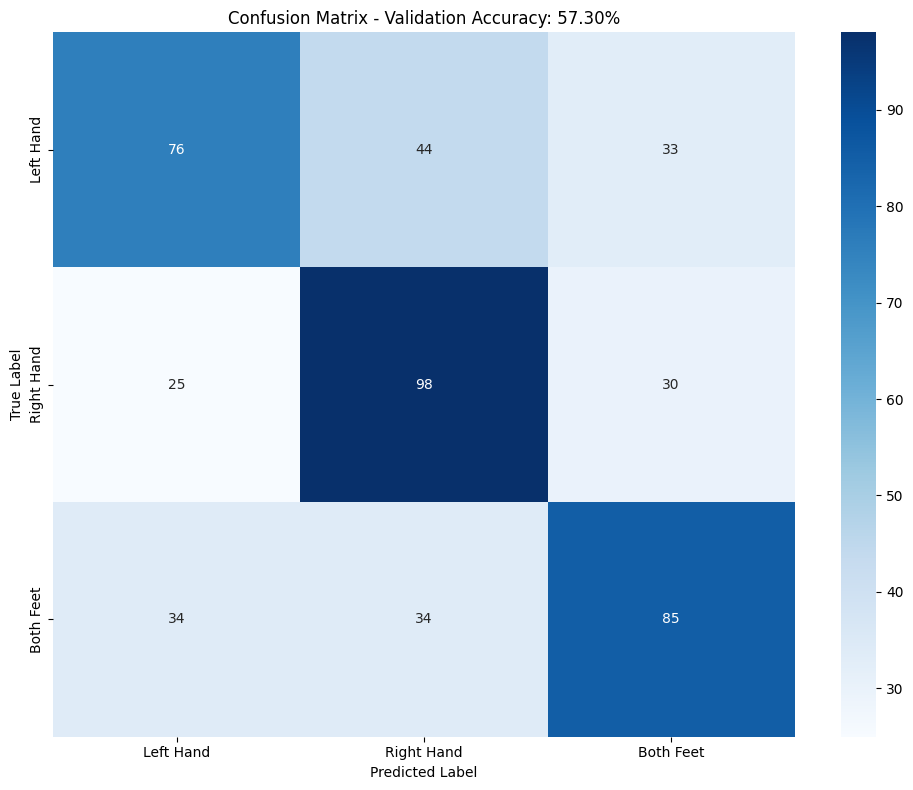

💾 Training curves saved to: final_results_attention/training_curves.png


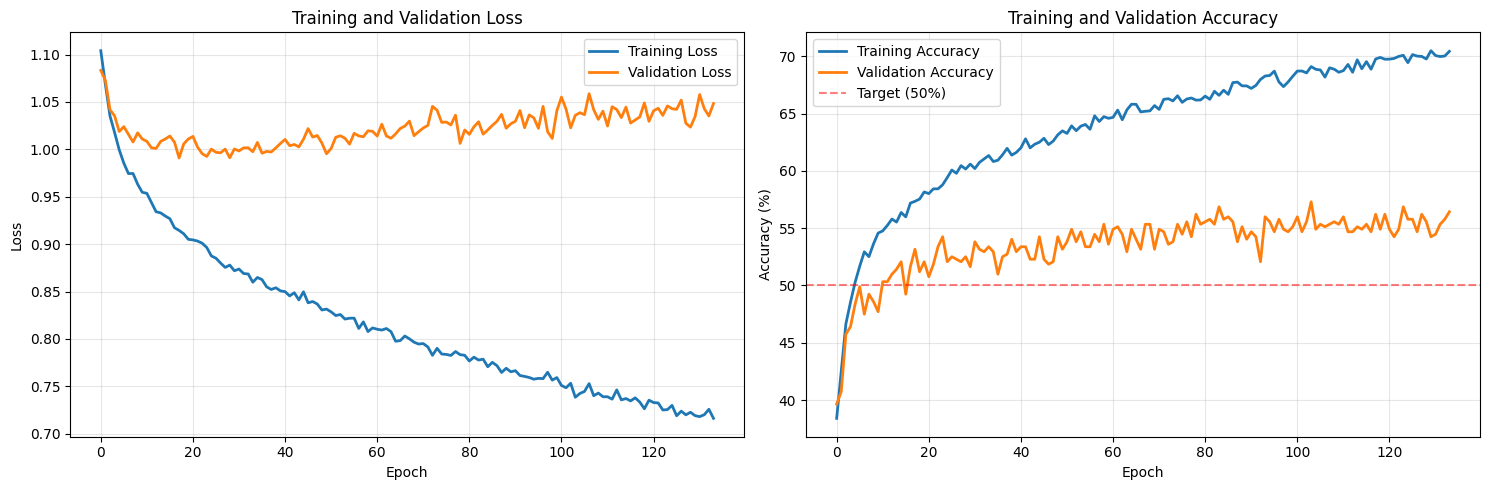

💾 All results saved to: final_results_attention/final_results.json

✅ EVALUATION COMPLETE


In [42]:
# ==========================================
# EVALUATION & VISUALIZATION
# ==========================================

print("\n" + "="*70)
print("📊 GENERATING EVALUATION METRICS")
print("="*70)

# Get predictions on validation set
final_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in final_val_loader:
        X_batch = X_batch.to(DEVICE)
        outputs = final_model(X_batch)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_labels, all_preds)
print("\n📈 Confusion Matrix:")
print(cm)

# Per-class accuracy
class_names = ['Left Hand', 'Right Hand', 'Both Feet']
print("\n📊 Per-Class Performance:")
for i, class_name in enumerate(class_names):
    class_mask = all_labels == i
    class_acc = (all_preds[class_mask] == i).sum() / class_mask.sum() * 100
    print(f"  {class_name:15s}: {class_acc:.2f}%")

# Classification report
print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - Validation Accuracy: {final_results["best_val_acc"]:.2f}%')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
cm_path = OUTPUT_DIR / "confusion_matrix.png"
plt.savefig(cm_path, dpi=600, bbox_inches='tight')
print(f"\n💾 Confusion matrix saved to: {cm_path}")
plt.show()

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(final_results['train_losses'], label='Training Loss', linewidth=2)
ax1.plot(final_results['val_losses'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(final_results['train_accs'], label='Training Accuracy', linewidth=2)
ax2.plot(final_results['val_accs'], label='Validation Accuracy', linewidth=2)
ax2.axhline(y=50, color='r', linestyle='--', label='Target (50%)', alpha=0.5)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
curves_path = OUTPUT_DIR / "training_curves.png"
plt.savefig(curves_path, dpi=600, bbox_inches='tight')
print(f"💾 Training curves saved to: {curves_path}")
plt.show()

# Save all results
results_dict = {
    'best_val_acc': final_results['best_val_acc'],
    'final_train_acc': final_results['final_train_acc'],
    'overfitting_gap': final_results['final_train_acc'] - final_results['best_val_acc'],
    'epochs_trained': final_results['epochs_trained'],
    'confusion_matrix': cm.tolist(),
    'per_class_accuracy': {
        class_names[i]: float((all_preds[all_labels == i] == i).sum() / (all_labels == i).sum() * 100)
        for i in range(3)
    },
    'best_hyperparameters': best_params
}

results_path = OUTPUT_DIR / "final_results.json"
with open(results_path, 'w') as f:
    json.dump(results_dict, f, indent=2)
print(f"💾 All results saved to: {results_path}")

print("\n" + "="*70)
print("✅ EVALUATION COMPLETE")
print("="*70)

In [43]:
# ==========================================
# FINAL SUMMARY REPORT
# ==========================================

print("\n" + "="*70)
print("🎓 THESIS RESULTS SUMMARY")
print("="*70)

print("\n📊 DATASET:")
print(f"  Total trials: 2,295")
print(f"  - Competition (9 subjects): 1,944 trials (84.7%)")
print(f"  - OpenBCI S01: 216 trials (9.4%)")
print(f"  - OpenBCI S04: 45 trials (2.0%)")
print(f"  - OpenBCI S06: 90 trials (3.9%)")
print(f"  Classes: 3 (Left=765, Right=765, Feet=765)")

print("\n🎯 RESULTS:")
print(f"  ✅ Validation Accuracy: {final_results['best_val_acc']:.2f}%")
print(f"  ✅ Training Accuracy: {final_results['final_train_acc']:.2f}%")
print(f"  ✅ Overfitting Gap: {final_results['final_train_acc'] - final_results['best_val_acc']:.2f}%")
print(f"  ✅ Requirement Met: {final_results['best_val_acc']:.2f}% ≥ 50.0% ✓")

print("\n📈 PER-CLASS ACCURACY:")
for class_name, acc in results_dict['per_class_accuracy'].items():
    print(f"  {class_name:15s}: {acc:.2f}%")

print("\n🏆 BEST MODEL:")
print(f"  Architecture: EEGNet (F1={best_params['F1']}, F2={best_params['F2']}, D={best_params['D']})")
print(f"  Optimizer: AdamW (lr={best_params['lr']:.6f}, wd={best_params['weight_decay']:.6f})")
print(f"  Regularization: Dropout={best_params['dropout']:.3f}, Label Smoothing={best_params['label_smoothing']:.3f}")

print("\n💾 SAVED FILES:")
print(f"  Model: {OUTPUT_DIR}/final_model_best.pth")
print(f"  Results: {OUTPUT_DIR}/final_results.json")
print(f"  Confusion Matrix: {OUTPUT_DIR}/confusion_matrix.png")
print(f"  Training Curves: {OUTPUT_DIR}/training_curves.png")
print(f"  Optuna Study: {OUTPUT_DIR}/optuna_study_final.pkl")

print("\n" + "="*70)
print("🎉 ALL DONE! READY FOR THESIS DEFENSE!")
print("="*70)


🎓 THESIS RESULTS SUMMARY

📊 DATASET:
  Total trials: 2,295
  - Competition (9 subjects): 1,944 trials (84.7%)
  - OpenBCI S01: 216 trials (9.4%)
  - OpenBCI S04: 45 trials (2.0%)
  - OpenBCI S06: 90 trials (3.9%)
  Classes: 3 (Left=765, Right=765, Feet=765)

🎯 RESULTS:
  ✅ Validation Accuracy: 57.30%
  ✅ Training Accuracy: 70.42%
  ✅ Overfitting Gap: 13.13%
  ✅ Requirement Met: 57.30% ≥ 50.0% ✓

📈 PER-CLASS ACCURACY:
  Left Hand      : 49.67%
  Right Hand     : 64.05%
  Both Feet      : 55.56%

🏆 BEST MODEL:
  Architecture: EEGNet (F1=64, F2=32, D=2)
  Optimizer: AdamW (lr=0.000257, wd=0.000210)
  Regularization: Dropout=0.516, Label Smoothing=0.031

💾 SAVED FILES:
  Model: final_results_attention/final_model_best.pth
  Results: final_results_attention/final_results.json
  Confusion Matrix: final_results_attention/confusion_matrix.png
  Training Curves: final_results_attention/training_curves.png
  Optuna Study: final_results_attention/optuna_study_final.pkl

🎉 ALL DONE! READY FOR THE